This notebook is used to visualize the results and generate plots. 
Sirisha Rambhatla, June 2021

In [13]:
import pyarrow
import gc
import pyarrow.parquet as pq
import pandas as pd
import pickle

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from scipy import stats
from tqdm import tqdm

import random

import json
import os

import datetime
from pytz import timezone
from argparse import ArgumentParser


In [14]:

NUM_COLORS = 10
latent_days = 5 
input_filename = 'path to infect_stat_res.txt' 
data_folder = '<path to data folder>' # some generated files will be stored here
  
print('Loading data') 
df = pd.read_csv('<path-to-checkins>', header = None, delimiter=' ') 
df.columns = ["id", "lat", "lon", "geohash", "day", "time"] 

def datetime_to_timestamp(date, time): 
    return datetime.datetime.strptime(date + ' ' + time, '%Y-%m-%d %H:%M:%S.%f').timestamp() 
df['timestamp'] = [int(datetime_to_timestamp(day, time)) for day, time in zip(df['day'], df['time'])] 

time_step = 24*60*60 
min_time = int(np.floor(min(df.timestamp)/time_step)*time_step) 
max_time = int(np.ceil(max(df.timestamp)/time_step)*time_step) 
NUM_DAYS = int((max_time - min_time)/time_step) 
time = np.arange(min_time, max_time, time_step) 

Loading data


In [15]:
tqdm.pandas() 

# Use first 100k for kmeans 
data_pts = list(zip(df['lat'].values[0:100000], df['lon'].values[0:100000]))  

print('kmeans..') 
# fit kmeans 
kmeans = KMeans(n_clusters=NUM_COLORS, random_state=0).fit(data_pts)  

# function to evaluate cluster membership given a dataframe 
def calc_cluster(df): 
    if df.shape[0] > 1: 
        return kmeans.predict(list(zip(df['lat'].values, df['lon'].values))) 
    else: 
        return kmeans.predict([(df['lat'].values[0], df['lon'].values[0])]) 

np.random.seed(0) 

# Cluster Centers 
np.save(data_folder + 'cluster_centers_'+'_' + str(NUM_COLORS), kmeans.cluster_centers_) 

kmeans..


In [16]:
print('Identify users') 
sample_prop = 0.1 
if sample_prop < 1: 
    usrs = df['id'].unique() 
    usrs = np.random.choice(usrs, size=int(usrs.shape[0]*sample_prop)) 
    df = df.loc[df['id'].isin(usrs)] 
    gc.collect() 
    

print('Form OD matrix') 
OD = np.zeros(shape=(NUM_DAYS, NUM_COLORS, NUM_COLORS)) 

def add_od(trajectory): 
    clusters = calc_cluster(trajectory) 
    indx = np.array(((trajectory['timestamp']-min_time)//(time_step))[:-1]), clusters[:-1], clusters[1:] 
    OD[indx]+=1 
    return 0 
 
print('calculate OD') 
df.groupby('id').progress_apply(add_od) 
 
#print(OD) 
np.save(data_folder + 'OD_matrix_' + str(NUM_COLORS), OD) 

  0%|          | 0/1668 [00:00<?, ?it/s]

Identify users
Form OD matrix
calculate OD


100%|██████████| 1668/1668 [00:01<00:00, 1263.74it/s]


In [17]:
## start script
import warnings 
warnings.filterwarnings('ignore') 
###
def get_mob_inf_clusters(day_start, day_end):
    mob_inf_day = []
    OD_sel = OD[day_start:day_end, :, :]
    inf_record_sel = np.squeeze(np.array(inf_records.copy())).T[:,day_start:day_end]
    non_self_tr_days = OD_sel - [np.diag(np.diag(X)) for X in OD_sel]
    
    for c in range(0, NUM_COLORS):
        mob_to_c = []
        temp = non_self_tr_days.copy()
            
        for ii in range(0, non_self_tr_days.shape[0]):
            temp[ii, c,:] = 0
    
            mob_to_c.append(sum(np.squeeze(temp[ii, :,c])))
            temp[ii, :,c] = 0


        sum_inf = [sum(sum(X)) for X in temp.copy()]
        infections_minus_c = inf_record_sel.copy()
        infections_minus_c[c,:] = 0 
        infections_minus_c = sum(infections_minus_c)


        mob_inf_day.append(sum([(x/max(y,1))*z for x,y,z in zip(mob_to_c, sum_inf, infections_minus_c)]))
    return mob_inf_day

def get_mob_inf_clusters_with_self(day_start, day_end):
    mob_inf_day = []
    self_mob_inf_day = []
    OD_sel = OD[day_start:day_end, :, :]
    inf_record_sel = np.squeeze(np.array(inf_records)).T[:,day_start:day_end]
    non_self_tr_days = OD_sel - [np.diag(np.diag(X)) for X in OD_sel]
    self_tr_days = [np.diag(np.diag(X)) for X in OD_sel]

    temp_s = self_tr_days.copy()
    for c in range(0, NUM_COLORS):
        mob_to_c = []
        mob_self_c = []
        temp_o = non_self_tr_days.copy()

        for ii in range(0, non_self_tr_days.shape[0]):
            temp_o[ii, c,:] = 0
    
            mob_to_c.append(sum(np.squeeze(temp_o[ii, :,c])))
            temp_o[ii, :,c] = 0

        sum_inf = [sum(sum(X)) for X in temp_o.copy()]
        infections_minus_c = inf_record_sel.copy()    
        infections_minus_c[c,:] = 0 
        infections_minus_c = sum(infections_minus_c)
    
        #Keep on c's infections
        infections_of_c = inf_record_sel[c,:].copy()
        
    
        self_mob_inf_day.append(sum([(x/max(y,1))*z for x,y,z in zip(np.array(temp_s)[:,c, c].copy(), mob_to_c,infections_of_c ) ]))
        mob_inf_day.append(sum([(x/max(y,1))*z for x,y,z in zip(mob_to_c, sum_inf, infections_minus_c)]))
    

    
    return self_mob_inf_day, mob_inf_day

print('Loading infections from ' + input_filename)
# Infections
chunk = pd.read_csv(input_filename, names=['time', 'infected_id', 'infected_by_id', 'lat', 'lon' ], delim_whitespace=True)

inf_records = []

i = 0

mobility_type = ['self_traffic', 'to_traffic', 'from_traffic', 'inf_mob_from_other', 'inf_mob_self']*NUM_COLORS

locs = list(np.repeat(np.arange(0, NUM_COLORS), len(mobility_type)/NUM_COLORS))

df_event_rec = pd.DataFrame(index=locs)
df_event_rec['Mobility type'] = mobility_type


print('Process all indices')
for t in time:
    event_day = []
    
    day_start = int(np.floor(t/time_step)*time_step)
    day_end =  int(np.floor(t/time_step)*time_step) + time_step
    
    # For infection events
    day_events_inf = chunk[(chunk['time'] >= day_start) & (chunk['time'] < day_end)]
    
    
    day_inf_events_by_clus = np.zeros([1,NUM_COLORS])
    
    if not day_events_inf.empty:
        clus_inf_day = calc_cluster(day_events_inf)
    
        for clus in np.unique(clus_inf_day):
            day_inf_events_by_clus[0,clus] = len(np.where(clus_inf_day == clus)[0])
    
    inf_records.append(day_inf_events_by_clus)
    
                           
    # Load daily OD matrix
    OD_day = np.squeeze(OD[i,:,:])
    self_traffic_day = np.diag(OD_day)
    non_self_traffic = OD_day - np.diag(self_traffic_day)
    
    # Traffic related 
    event_day.append(self_traffic_day)
                           
    #TO traffic
    event_day.append(np.sum(non_self_traffic,0))
                           
    # From Traffic
    event_day.append(np.sum(non_self_traffic,1))
    
    inf_mob = np.zeros(NUM_COLORS)
    self_inf_mob = np.zeros(NUM_COLORS)

    if i > 0:
        day_start = max(0,i)
        day_end = max(0,i+1)
        if day_start<day_end:

            inf_mob, self_inf_mob = get_mob_inf_clusters_with_self(day_start, day_end)
            
        
    event_day.append(np.array(inf_mob))
    event_day.append(np.array(self_inf_mob))
        
                      
    
    df_event_rec[t] = np.ravel(np.array(event_day), order='F')
    i = i + 1
## end script

Loading infections from /tank/users/sirishar/analyze/data/gowalla/infect_stat_res.txt
Process all indices


In [18]:
print('Save csv...')    
# Save infections csv
inf_rec_out_file = data_folder + "cluster_inf_events_" + str(NUM_COLORS)+ str('_') + str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')) + '.csv'

inf_records = np.array(inf_records)
df_inf_rec = pd.DataFrame(np.squeeze(inf_records), columns=np.arange(0,NUM_COLORS), index=time)   
df_inf_rec.to_csv(inf_rec_out_file)

# Save events csv
event_rec_out_file = data_folder + "cluster_checkin_events_" + str(NUM_COLORS)+ str('_') + str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')) + '.csv'
df_event_rec.to_csv(event_rec_out_file)
print('Done saving!') 

Save csv...
Done saving!


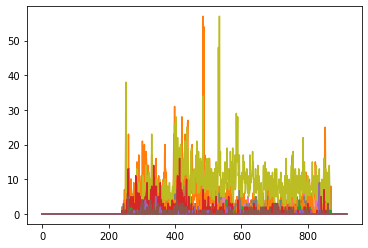

In [10]:
inf_rec_mat = np.squeeze(np.array(inf_records)) 
nnz_id = np.where([np.sum(inf_rec_mat[:,i]) for i in range(0, NUM_COLORS)])[0]
nnz_id 
plt.plot(inf_rec_mat[:,10]) 

plt.plot(inf_rec_mat)
plt.show()

[37.546028655754185,
 -122.5307377858139,
 37.983829173332126,
 -122.23540981996878]

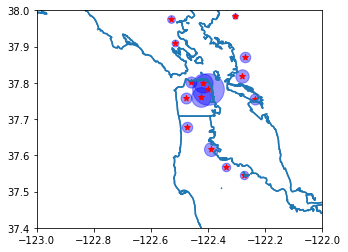

In [7]:
import geopandas 
import shapely 
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) 
sf = geopandas.read_file("/tank/users/sirishar/analyze/maps/SF_shapefile/bayarea_general.shp") 
sf = sf.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'}) 
sf.boundary.plot() 
 
df_clus = pd.DataFrame(kmeans.cluster_centers_, columns=['x', 'y']) 
df_clus['geometry'] = df_clus.apply(lambda row: shapely.geometry.Point(row.x, row.y), axis=1) 

size = [np.sum(kmeans.labels_ == i) for i in range(NUM_COLORS)]
size = size/max(size)
size = 1000*size
  
# make it a geopandas DataFrame 
gdf = geopandas.GeoDataFrame(df_clus) 
  
minx, miny, maxx, maxy = gdf.total_bounds 

for i in range(0,NUM_COLORS): 
    plt.scatter(kmeans.cluster_centers_[i,1], kmeans.cluster_centers_[i,0], marker='o', color='blue', s=size[i], alpha=0.4) 
    

plt.scatter(kmeans.cluster_centers_[nnz_id,1], kmeans.cluster_centers_[nnz_id,0], marker='*', color='red')     
plt.xlim(-123, -122) 
plt.ylim(37.4, 38) 
[minx, miny, maxx, maxy] 

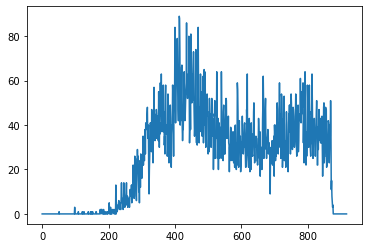

In [8]:
plt.plot([np.sum(OD[i,:,:]*(1 - np.eye(NUM_COLORS))) for i in range(len(inf_rec_mat) )])

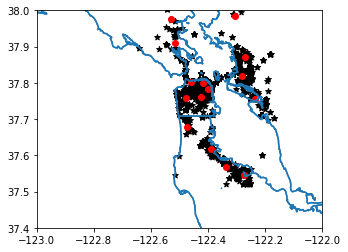

In [9]:
sf.boundary.plot()
plt.scatter(chunk['lat'], chunk['lon'], color='black')
plt.xlim(-123, -122) 
plt.ylim(37.4, 38) 
plt.scatter(chunk['lon'], chunk['lat'], marker='*', color='black') 
for i in range(0,NUM_COLORS): 
    
    plt.scatter(kmeans.cluster_centers_[i,1], kmeans.cluster_centers_[i,0], marker='o', color='red') 
    